# Image Segmentation

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
from openvino.runtime import Core

sys.path.append('../utils')
from notebook_utils import segmentation_map_to_image

In [27]:
# Load model
ie = Core()

model = ie.read_model('./intel/road-segmentation-adas-0001/FP32/road-segmentation-adas-0001.xml')
compiled_model = ie.compile_model(model=model, device_name="CPU")

input_layer_ir = next(iter(compiled_model.inputs))
output_layer_ir = next(iter(compiled_model.outputs))

print(input_layer_ir)
print(output_layer_ir)


<ConstOutput: names[data] shape{1,3,512,896} type: f32>
<ConstOutput: names[L0317_ReWeight, L0317_ReWeight_SoftMax] shape{1,4,512,896} type: f32>


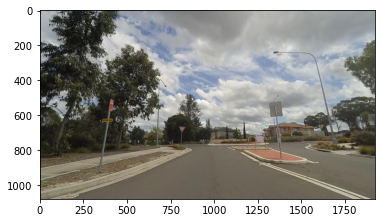

In [30]:
# Load Image
image = cv2.imread('./data/empty_road_mapillary.jpg')

rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_h, image_w, _ = image.shape

# N, C, H, W = batch size, number of channels, height, width
N, C, H, W = input_layer_ir.shape

# resize image
resize_image = cv2.resize(image, (W, H))

# reshape to network input shape
input_image = np.expand_dims(
    resize_image.transpose(2, 0, 1), 0
)

plt.imshow(rgb_img)



In [51]:
# Run the inference
result = compiled_model([input_image])[output_layer_ir]

# prepare data for visualization
segmentation_mask = np.argmax(result, axis=1)
# print(segmentation_mask.shape)
# plt.imshow(segmentation_mask.transpose(1, 2, 0))

In [52]:
colormap = np.array([[68, 1, 84], [48, 103, 141], [53, 183, 120], [199, 216, 52]])

# Define ht etransparency of the segmentation mask on the photo
alpha = 0.3

# Use function from notebook_utils.py to transform mask to an RGB image
mask = segmentation_map_to_image(segmentation_mask, colormap)
resized_mask = cv2.resize(mask, (image_w, image_h))

image_with_mask = cv2.addWeighted(resized_mask, alpha, rgb_img, 1 - alpha, 0)

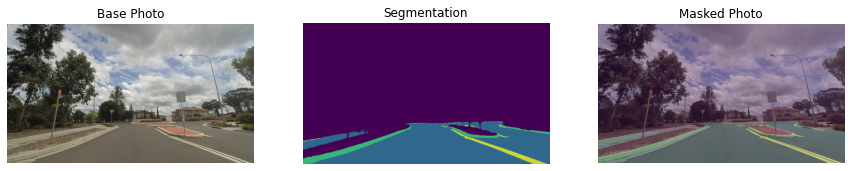

In [53]:
data = {"Base Photo": rgb_img, "Segmentation": mask, "Masked Photo": image_with_mask}

fig, axs = plt.subplots(1, len(data.items()), figsize=(15, 10))

# Fill subplot
for ax, (name, image) in zip(axs, data.items()):
    ax.axis('off')
    ax.set_title(name)
    ax.imshow(image)

# Display image
plt.show(fig)